In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib
from scipy.stats import anderson_ksamp

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.2
matplotlib.rcParams["xtick.major.size"] = 8.0
matplotlib.rcParams["ytick.major.size"] = 8.0
matplotlib.rcParams["xtick.minor.size"] = 3.0
matplotlib.rcParams["ytick.minor.size"] = 3.0
matplotlib.rcParams["xtick.minor.visible"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.minor.visible"] = True
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams['hatch.linewidth'] = 1.5

Reading in data

In [3]:
# massvel_werr = pd.read_csv('data/mass_vel_data_expanded.dat')
massvel_werr = pd.read_csv('data/mass_vel_data_expanded_v1.1.dat')
massvel_werr = massvel_werr[(~np.isnan(massvel_werr.mass)) & (~np.isnan(massvel_werr.vel))]
print(len(massvel_werr[massvel_werr.subsample == 'CSP']))
print(len(massvel_werr[massvel_werr.subsample == 'old']))
print(len(massvel_werr[massvel_werr.subsample == 'Foundation']))
# Removing objects with velocities 99 and -99 as they were classified as high velocity or normal by Wang09 but
# do not have a measured velocity
massvel_werr = massvel_werr[np.abs(massvel_werr.vel) < 99]
# Removing ASASSN-15mi because it is IaPec
massvel_werr = massvel_werr[massvel_werr.Name != 'asassn-15mi']
# Removing 2007a because of its high velocity uncertainty
massvel_werr = massvel_werr[massvel_werr.Name != '2007a']
# Removing 1997e because of high mass uncertainty
massvel_werr = massvel_werr[massvel_werr.Name != '1997e']
print(len(massvel_werr[massvel_werr.subsample == 'CSP']))
print(len(massvel_werr[massvel_werr.subsample == 'old']))
print(len(massvel_werr[massvel_werr.subsample == 'Foundation']))

massvel_werr.loc[massvel_werr['mass'] < 7.0,'masserr'] = 0.0
# Those objects with mass = 5.0 are placeholder values, for the sake of asthetics and because their
# actual mass is low, but essentially unknown, we will set their value higher
massvel_werr.loc[massvel_werr['mass'] == 5.0,'mass'] = 7.0
massvel_werr.sort_values(by='mass').head()

53
110
77
52
94
76


,Unnamed: 0,Unnamed: 0.1,Host,Name,mass,mass_Burns18,mass_DES,mass_Jones18,mass_Neill,mass_PanSTARRS,mass_SDSS,mass_SNLS,mass_Wolf,masserr,subsample,symbol,vel,velerr,z,mass_Chang,mass_2MASS,mass_Conley11
21,21,94,NaN,ps15bwh,7.000,NaN,NaN,5.000,NaN,NaN,NaN,NaN,NaN,0.000000,Foundation,<,-11.320640,0.256279,NaN,NaN,NaN,NaN
18,18,86,NaN,atlas16agv,7.000,NaN,NaN,5.000,NaN,NaN,NaN,NaN,NaN,0.000000,Foundation,<,-10.100120,0.230585,NaN,NaN,NaN,NaN
32,32,121,NaN,2017coa,7.575,NaN,NaN,7.575,NaN,NaN,NaN,NaN,NaN,0.158451,Foundation,o,-10.774048,0.222075,NaN,NaN,NaN,NaN
158,158,296,SDSS J103944.53+150204.7,2016ixf,7.874,NaN,NaN,7.874,NaN,NaN,NaN,NaN,NaN,0.158451,Foundation,o,-10.842655,0.220531,0.06602,NaN,NaN,NaN
20,20,90,NaN,css160129,8.160,NaN,NaN,NaN,NaN,NaN,8.16,NaN,NaN,0.158451,Foundation,s,-11.867747,0.222706,NaN,NaN,NaN,NaN


In [4]:
pan14 = pd.read_csv('data/Pan14_mass-vel.txt', delim_whitespace=True, skiprows=1,
                    names=['Name','z','mass','mass_err_hi','mass_err_lo','vel','velerr'])
pan14.vel = -1.*(pan14.vel/1000.)
pan14.velerr = pan14.velerr/1000.
pan14.Name = 'PTF' + pan14.Name
pan20 = pd.read_csv('data/Pan20_mass-vel.txt', delim_whitespace=True, skiprows=1,
                    names=['Name','z','mass','mass_err_hi','mass_err_lo','vel','velerr'])
pan20.vel = -1.*(pan20.vel/1000.)
pan20.velerr = pan20.velerr/1000.

panFull = pd.concat([pan20,pan14])
panFull.drop_duplicates(subset='Name',inplace=True)

# cut objects with extra large uncertainties
panFull = panFull[panFull.mass_err_hi < 1.0]
panFull = panFull[panFull.mass_err_lo < 1.0]
panFull = panFull[panFull.velerr < 1.0]

panFull.sort_values(by='Name')
panFull = panFull[panFull.Name.str.contains('PTF')]

Plotting helper function

In [7]:
def histPlot(data,mass_errs=False,csp_color='#d40a0c',found_color='#074ede',w09_color='#d95f02',pan_data=None,pan_color='#4d4f4a'):
    fig, ax = plt.subplots(2,2,figsize=(18,12), gridspec_kw={'width_ratios':[4,1],'height_ratios':[1,3]})
    plt.subplots_adjust(hspace=0.0,wspace=0.0)
    fig.delaxes(ax[0,1])

    ax[0,0].set_xticklabels([])
    ax[0,0].set_yticklabels([])
    ax[1,1].set_xticklabels([])
    ax[1,1].set_yticklabels([])
    ax[0,0].set_xticks([])
    ax[0,0].set_yticks([])
    ax[1,1].set_xticks([])
    ax[1,1].set_yticks([])
    
    malpha = 0.6
    panalpha = 0.4
    
    histalpha = 0.3
    panhistalpha = 0.3
    
    mrksize = 8.0
    
    if pan_data is not None:
        ax[1,0].plot(pan_data.mass,
                     pan_data.vel,
                     color=pan_color, label='Pan PTF ({:d})'.format(len(pan_data.vel)),
                     alpha=panalpha, linestyle='', marker='d', markersize=mrksize)
        if mass_errs:
            ax[1,0].errorbar(pan_data.mass,
                             pan_data.vel,
                             yerr=pan_data.velerr,
                             xerr=[pan_data.mass_err_hi,pan_data.mass_err_lo],
                             color=pan_color,label=None,alpha=panalpha,linestyle='')
        else:
            ax[1,0].errorbar(pan_data.mass,
                             pan_data.vel,
                             yerr=pan_data.velerr,
                             color=pan_color,label=None,alpha=panalpha,linestyle='')

    for marker in np.unique(data.symbol):
        if marker == 'o':
            label = ['CSP ({:d})'.format(len(data[(data.subsample == 'CSP') 
                                                           & (data.symbol == marker)].vel)),
                     'Foundation ({:d})'.format(len(data[(data.subsample == 'Foundation') 
                                                           & (data.symbol == marker)].vel)+5),
                     'W09/FK11 ({:d})'.format(len(data[(data.subsample == 'old') 
                                                           & (data.symbol == marker)].vel))]
                    # Adding 5 to the Foundation number because there are five points whose symbol isn't 'o'
        else:
            label = ['_nolegend_', '_nolegend_', '_nolegend_', '_nolegend_']
            
        ax[1,0].plot(data[(data.subsample == 'old') & (data.symbol == marker)].mass,
                     data[(data.subsample == 'old') & (data.symbol == marker)].vel, markersize=mrksize+2,
                     color=w09_color, label=label[2], alpha=malpha, linestyle='', marker='P')
        if mass_errs:
            ax[1,0].errorbar(data[(data.subsample == 'old') & (data.symbol == marker)].mass,
                             data[(data.subsample == 'old') & (data.symbol == marker)].vel,
                             yerr=data[(data.subsample == 'old') & (data.symbol == marker)].velerr,
                             xerr=data[(data.subsample == 'old') & (data.symbol == marker)].masserr,
                             color=w09_color,label=None,alpha=malpha,linestyle='')
        else:
            ax[1,0].errorbar(data[(data.subsample == 'old') & (data.symbol == marker)].mass,
                             data[(data.subsample == 'old') & (data.symbol == marker)].vel,
                             yerr=data[(data.subsample == 'old') & (data.symbol == marker)].velerr,
                             color=w09_color,label=None,alpha=malpha,linestyle='')

        ax[1,0].plot(data[(data.subsample == 'CSP') & (data.symbol == marker)].mass,
                     data[(data.subsample == 'CSP') & (data.symbol == marker)].vel, markersize=mrksize+2,
                     color=csp_color, label=label[0], alpha=malpha, linestyle='', marker='X')
        if mass_errs:
            ax[1,0].errorbar(data[(data.subsample == 'CSP') & (data.symbol == marker)].mass,
                             data[(data.subsample == 'CSP') & (data.symbol == marker)].vel,
                             yerr=data[(data.subsample == 'CSP') & (data.symbol == marker)].velerr,
                             xerr=data[(data.subsample == 'CSP') & (data.symbol == marker)].masserr,
                             color=csp_color,label=None,alpha=malpha,linestyle='')
        else:
            ax[1,0].errorbar(data[(data.subsample == 'CSP') & (data.symbol == marker)].mass,
                             data[(data.subsample == 'CSP') & (data.symbol == marker)].vel,
                             yerr=data[(data.subsample == 'CSP') & (data.symbol == marker)].velerr,
                             color=csp_color,label=None,alpha=malpha,linestyle='')

        # Kludge to fix upper limits for two lowest mass Foundation objects    
        ax[1,0].plot(data[(data.subsample == 'Foundation') & (data.symbol == marker) & (data.mass > 7.0)].mass,
                     data[(data.subsample == 'Foundation') & (data.symbol == marker) & (data.mass > 7.0)].vel,
                     color=found_color, label=label[1], alpha=malpha, linestyle='', marker=marker, markersize=mrksize)
        ax[1,0].plot(data[(data.subsample == 'Foundation') & (data.symbol == marker) & (data.mass <= 7.0)].mass,
                     data[(data.subsample == 'Foundation') & (data.symbol == marker) & (data.mass <= 7.0)].vel,
                     color=found_color, label='_nolegend', alpha=malpha, linestyle='', marker=marker, markersize=mrksize*1.2)

        if mass_errs:
            ax[1,0].errorbar(data[(data.subsample == 'Foundation') & (data.symbol == marker) & (data.mass > 7.0)].mass,
                             data[(data.subsample == 'Foundation') & (data.symbol == marker) & (data.mass > 7.0)].vel,
                             yerr=data[(data.subsample == 'Foundation') & (data.symbol == marker) & (data.mass > 7.0)].velerr,
                             xerr=data[(data.subsample == 'Foundation') & (data.symbol == marker) & (data.mass > 7.0)].masserr,
                             color=found_color,label='_nolegend_',alpha=malpha,linestyle='')
            # Kludge to move error bar to the right of the left-facing triangles
            ax[1,0].errorbar(data[(data.subsample == 'Foundation') & (data.symbol == marker) & (data.mass <= 7.0)].mass + 0.045,
                             data[(data.subsample == 'Foundation') & (data.symbol == marker) & (data.mass <= 7.0)].vel,
                             yerr=data[(data.subsample == 'Foundation') & (data.symbol == marker) & (data.mass <= 7.0)].velerr,
                             xerr=data[(data.subsample == 'Foundation') & (data.symbol == marker) & (data.mass <= 7.0)].masserr,
                             color=found_color,label=None,alpha=malpha,linestyle='')
        else:
            ax[1,0].errorbar(data[(data.subsample == 'Foundation') & (data.symbol == marker)].mass,
                             data[(data.subsample == 'Foundation') & (data.symbol == marker)].vel,
                             yerr=data[(data.subsample == 'Foundation') & (data.symbol == marker)].velerr,
                             color=found_color,label=None,alpha=malpha,linestyle='')
            
    
#     masslim = [4.75,12.25]
    masslim = [6.5,12.25]
    ax[1,0].set_xlim(masslim)
    ax[0,0].set_xlim(masslim)
    ax[1,0].xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
    
    massbins = np.linspace(4.75,12.25,31)
#     print(massbins)
    
    vellim = [-7,-18.5]
    ax[1,0].set_ylim(vellim)
    ax[1,1].set_ylim(vellim)

    velbins = np.linspace(-18.5,-7,24)
#     print(velbins)
    
    if pan_data is not None:
        ax[0,0].hist(pan_data.mass.values.reshape(-1,1),bins=massbins,
                     density=True,color=pan_color,hatch='-',alpha=panhistalpha,label='Pan PTF')
        ax[1,1].hist(pan_data.vel,bins=velbins,
                     density=True,orientation='horizontal',color=pan_color,hatch='-',alpha=panhistalpha)

    ax[0,0].hist(data[data.subsample == 'old'].mass.values.reshape(-1,1),bins=massbins,
                 density=True,color=w09_color,hatch='\\',alpha=histalpha,label='W09/FK11')
    ax[0,0].hist(data[data.subsample == 'CSP'].mass.values.reshape(-1,1),bins=massbins,
                 density=True,color=csp_color,hatch='/',alpha=histalpha,label='CSP')
    ax[0,0].hist(data[data.subsample == 'Foundation'].mass.values.reshape(-1,1),bins=massbins,
                 density=True,color=found_color,hatch='|',alpha=histalpha,label='Foundation')

    ax[1,1].hist(data[data.subsample == 'old'].vel,bins=velbins,
                 density=True,orientation='horizontal',color=w09_color,hatch='\\',alpha=histalpha)
    ax[1,1].hist(data[data.subsample == 'CSP'].vel,bins=velbins,
                 density=True,orientation='horizontal',color=csp_color,hatch='/',alpha=histalpha)
    ax[1,1].hist(data[data.subsample == 'Foundation'].vel,bins=velbins,
                 density=True,orientation='horizontal',color=found_color,hatch='|',alpha=histalpha)


    ax[0,0].legend(fontsize=28, frameon=False, bbox_to_anchor=(1.28, -0.11), handletextpad=0.3, loc='lower right')
    
    ax[1,0].set_xlabel(r'Host galaxy stellar mass, $\log(M_\star/M_\odot)$',fontsize=36)
    ax[1,0].set_ylabel(r'Si II Velocity [$1000$ km s$^{-1}$]',fontsize=36)
    ax[1,0].legend(bbox_to_anchor=(0.37, 0.97),fontsize=28, markerscale=1.5, frameon=False, handletextpad=0.0)
    ax[1,0].tick_params(labelsize=28)
    
    ax[1,0].plot([0,20],[-11.8,-11.8],':',color='forestgreen',alpha=0.8)
    xlim11 = ax[1,1].get_xlim()
    ax[1,1].plot(xlim11,[-11.8,-11.8],':',color='forestgreen',alpha=0.8)
    ax[1,1].set_xlim(xlim11)

    return ax

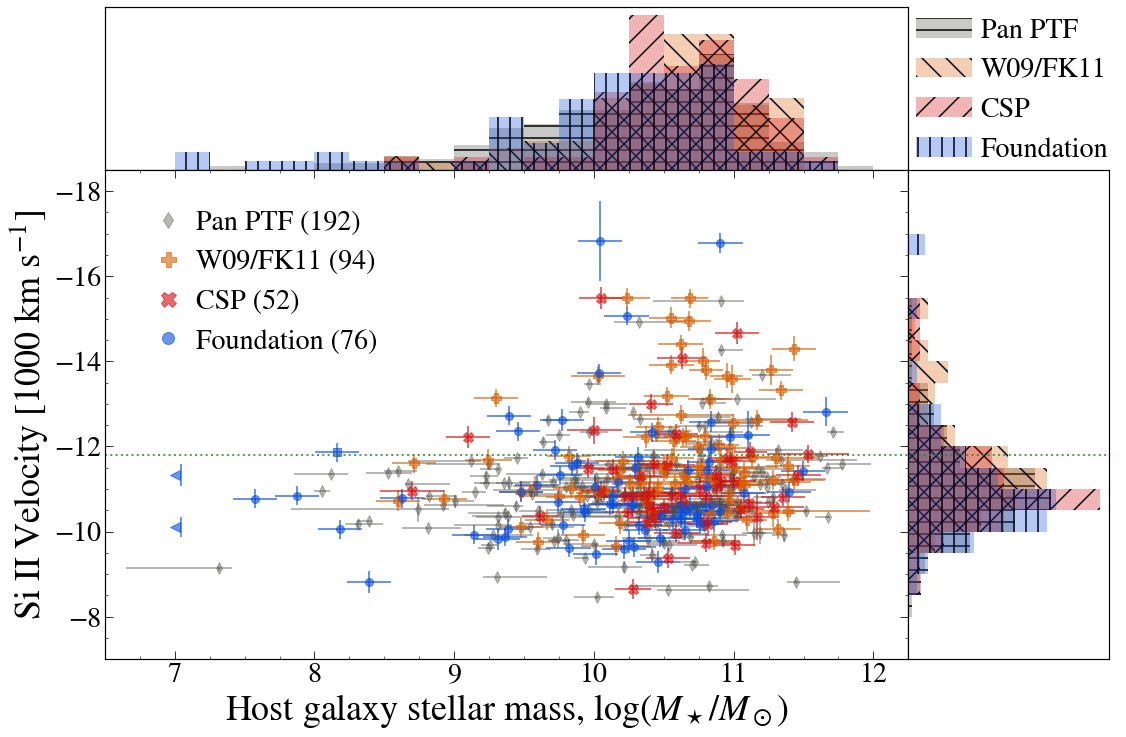

In [9]:
histPlot(massvel_werr,pan_data=panFull,mass_errs=True)
plt.savefig('massvel_figures/mass_vs_velocity_wpan_ptfonly.pdf',bbox_inches='tight')
plt.savefig('massvel_figures/mass_vs_velocity_wpan_ptfonly.png',bbox_inches='tight',dpi=600,transparent=True)
plt.savefig('massvel_figures/mass_vs_velocity_wpan_ptfonly.jpg',bbox_inches='tight',dpi=600,transparent=True)
plt.savefig('massvel_figures/mass_vs_velocity_wpan_ptfonly_lowres.png',bbox_inches='tight',dpi=200,transparent=True)

In [6]:
print('PTF High velocity, High Mass')
print(len(panFull[(panFull.vel < -11.8) & (panFull.mass > 9.0)]))
print('PTF High velocity, Low Mass')
print(len(panFull[(panFull.vel < -11.8) & (panFull.mass < 9.0)]))
print('PTF Normal velocity, High Mass')
print(len(panFull[(panFull.vel > -11.8) & (panFull.mass > 9.0)]))
print('PTF Normal velocity, Low Mass')
print(len(panFull[(panFull.vel > -11.8) & (panFull.mass < 9.0)]))

PTF High velocity, High Mass
32
PTF High velocity, Low Mass
0
PTF Normal velocity, High Mass
148
PTF Normal velocity, Low Mass
12


In [28]:
print('PTF High velocity, High Mass')
print(len(panFull[(panFull.vel < -11.8) & (panFull.mass > 9.5)]))
print('PTF High velocity, Low Mass')
print(len(panFull[(panFull.vel < -11.8) & (panFull.mass < 9.5)]))
print('PTF Normal velocity, High Mass')
print(len(panFull[(panFull.vel > -11.8) & (panFull.mass > 9.5)]))
print('PTF Normal velocity, Low Mass')
print(len(panFull[(panFull.vel > -11.8) & (panFull.mass < 9.5)]))

PTF High velocity, High Mass
32
PTF High velocity, Low Mass
0
PTF Normal velocity, High Mass
129
PTF Normal velocity, Low Mass
31


In [7]:
print('PTF High velocity, High Mass (10)')
print(len(panFull[(panFull.vel < -11.8) & (panFull.mass > 10.0)]))
print('PTF High velocity, Low Mass (10)')
print(len(panFull[(panFull.vel < -11.8) & (panFull.mass < 10.0)]))
print('PTF Normal velocity, High Mass (10)')
print(len(panFull[(panFull.vel > -11.8) & (panFull.mass > 10.0)]))
print('PTF Normal velocity, Low Mass (10)')
print(len(panFull[(panFull.vel > -11.8) & (panFull.mass < 10.0)]))

PTF High velocity, High Mass (10)
25
PTF High velocity, Low Mass (10)
7
PTF Normal velocity, High Mass (10)
106
PTF Normal velocity, Low Mass (10)
54


In [8]:
print('Foundation High velocity, High Mass')
print(len(massvel_werr[(massvel_werr.subsample == 'Foundation') & (massvel_werr.vel < -11.8) & (massvel_werr.mass > 9.0)]))
print('Foundation High velocity, Low Mass')
print(len(massvel_werr[(massvel_werr.subsample == 'Foundation') & (massvel_werr.vel < -11.8) & (massvel_werr.mass < 9.0)]))
print('Foundation Normal velocity, High Mass')
print(len(massvel_werr[(massvel_werr.subsample == 'Foundation') & (massvel_werr.vel > -11.8) & (massvel_werr.mass > 9.0)]))
print('Foundation Normal velocity, Low Mass')
print(len(massvel_werr[(massvel_werr.subsample == 'Foundation') & (massvel_werr.vel > -11.8) & (massvel_werr.mass < 9.0)]))

Foundation High velocity, High Mass
14
Foundation High velocity, Low Mass
1
Foundation Normal velocity, High Mass
54
Foundation Normal velocity, Low Mass
7


In [29]:
print('Foundation High velocity, High Mass')
print(len(massvel_werr[(massvel_werr.subsample == 'Foundation') & (massvel_werr.vel < -11.8) & (massvel_werr.mass > 9.5)]))
print('Foundation High velocity, Low Mass')
print(len(massvel_werr[(massvel_werr.subsample == 'Foundation') & (massvel_werr.vel < -11.8) & (massvel_werr.mass < 9.5)]))
print('Foundation Normal velocity, High Mass')
print(len(massvel_werr[(massvel_werr.subsample == 'Foundation') & (massvel_werr.vel > -11.8) & (massvel_werr.mass > 9.5)]))
print('Foundation Normal velocity, Low Mass')
print(len(massvel_werr[(massvel_werr.subsample == 'Foundation') & (massvel_werr.vel > -11.8) & (massvel_werr.mass < 9.5)]))

Foundation High velocity, High Mass
12
Foundation High velocity, Low Mass
3
Foundation Normal velocity, High Mass
49
Foundation Normal velocity, Low Mass
12


In [9]:
print('Foundation High velocity, High Mass (10)')
print(len(massvel_werr[(massvel_werr.subsample == 'Foundation') & (massvel_werr.vel < -11.8) & (massvel_werr.mass > 10.0)]))
print('Foundation High velocity, Low Mass (10)')
print(len(massvel_werr[(massvel_werr.subsample == 'Foundation') & (massvel_werr.vel < -11.8) & (massvel_werr.mass < 10.0)]))
print('Foundation Normal velocity, High Mass (10)')
print(len(massvel_werr[(massvel_werr.subsample == 'Foundation') & (massvel_werr.vel > -11.8) & (massvel_werr.mass > 10.0)]))
print('Foundation Normal velocity, Low Mass (10)')
print(len(massvel_werr[(massvel_werr.subsample == 'Foundation') & (massvel_werr.vel > -11.8) & (massvel_werr.mass < 10.0)]))

Foundation High velocity, High Mass (10)
10
Foundation High velocity, Low Mass (10)
5
Foundation Normal velocity, High Mass (10)
40
Foundation Normal velocity, Low Mass (10)
21


In [10]:
print('CSP High velocity, High Mass')
print(len(massvel_werr[(massvel_werr.subsample == 'CSP') & (massvel_werr.vel < -11.8) & (massvel_werr.mass > 9.0)]))
print('CSP High velocity, Low Mass')
print(len(massvel_werr[(massvel_werr.subsample == 'CSP') & (massvel_werr.vel < -11.8) & (massvel_werr.mass < 9.0)]))
print('CSP Normal velocity, High Mass')
print(len(massvel_werr[(massvel_werr.subsample == 'CSP') & (massvel_werr.vel > -11.8) & (massvel_werr.mass > 9.0)]))
print('CSP Normal velocity, Low Mass')
print(len(massvel_werr[(massvel_werr.subsample == 'CSP') & (massvel_werr.vel > -11.8) & (massvel_werr.mass < 9.0)]))

CSP High velocity, High Mass
10
CSP High velocity, Low Mass
0
CSP Normal velocity, High Mass
41
CSP Normal velocity, Low Mass
1


In [11]:
print('CSP High velocity, High Mass (10)')
print(len(massvel_werr[(massvel_werr.subsample == 'CSP') & (massvel_werr.vel < -11.8) & (massvel_werr.mass > 10.0)]))
print('CSP High velocity, Low Mass (10)')
print(len(massvel_werr[(massvel_werr.subsample == 'CSP') & (massvel_werr.vel < -11.8) & (massvel_werr.mass < 10.0)]))
print('CSP Normal velocity, High Mass (10)')
print(len(massvel_werr[(massvel_werr.subsample == 'CSP') & (massvel_werr.vel > -11.8) & (massvel_werr.mass > 10.0)]))
print('CSP Normal velocity, Low Mass (10)')
print(len(massvel_werr[(massvel_werr.subsample == 'CSP') & (massvel_werr.vel > -11.8) & (massvel_werr.mass < 10.0)]))

CSP High velocity, High Mass (10)
9
CSP High velocity, Low Mass (10)
1
CSP Normal velocity, High Mass (10)
39
CSP Normal velocity, Low Mass (10)
3


In [12]:
print('W09 High velocity, High Mass')
print(len(massvel_werr[(massvel_werr.subsample == 'old') & (massvel_werr.vel < -11.8) & (massvel_werr.mass > 9.0)]))
print('W09 High velocity, Low Mass')
print(len(massvel_werr[(massvel_werr.subsample == 'old') & (massvel_werr.vel < -11.8) & (massvel_werr.mass < 9.0)]))
print('W09 Normal velocity, High Mass')
print(len(massvel_werr[(massvel_werr.subsample == 'old') & (massvel_werr.vel > -11.8) & (massvel_werr.mass > 9.0)]))
print('W09 Normal velocity, Low Mass')
print(len(massvel_werr[(massvel_werr.subsample == 'old') & (massvel_werr.vel > -11.8) & (massvel_werr.mass < 9.0)]))

W09 High velocity, High Mass
29
W09 High velocity, Low Mass
0
W09 Normal velocity, High Mass
62
W09 Normal velocity, Low Mass
3


In [13]:
print('W09 High velocity, High Mass (10)')
print(len(massvel_werr[(massvel_werr.subsample == 'old') & (massvel_werr.vel < -11.8) & (massvel_werr.mass > 10.0)]))
print('W09 High velocity, Low Mass (10)')
print(len(massvel_werr[(massvel_werr.subsample == 'old') & (massvel_werr.vel < -11.8) & (massvel_werr.mass < 10.0)]))
print('W09 Normal velocity, High Mass (10)')
print(len(massvel_werr[(massvel_werr.subsample == 'old') & (massvel_werr.vel > -11.8) & (massvel_werr.mass > 10.0)]))
print('W09 Normal velocity, Low Mass (10)')
print(len(massvel_werr[(massvel_werr.subsample == 'old') & (massvel_werr.vel > -11.8) & (massvel_werr.mass < 10.0)]))

W09 High velocity, High Mass (10)
28
W09 High velocity, Low Mass (10)
1
W09 Normal velocity, High Mass (10)
51
W09 Normal velocity, Low Mass (10)
14


In [14]:
from scipy.stats import fisher_exact, chi2_contingency

In [15]:
# For split at mass = 9; [HV/HM,HV/LM],[LV/HM,LV/LM]
fisher_exact([[32+14,0+1],[148+54,12+7]])

(4.326732673267327, 0.216735903579048)

In [16]:
chi2_contingency([[32+14,0+1],[148+54,12+7]])

(1.5056621645543278,
 0.21980219662738912,
 1,
 array([[ 43.49253731,   3.50746269],
        [204.50746269,  16.49253731]]))

In [17]:
fisher_exact([[32+14,0+0],[148+54,12+8]])

(inf, 0.030095170123680414)

In [18]:
chi2_contingency([[32+14,0+0],[148+54,12+8]])

(3.2687928812402864,
 0.0706095617062962,
 1,
 array([[ 42.56716418,   3.43283582],
        [205.43283582,  16.56716418]]))

In [19]:
chi2_contingency([[32+14+39,0+1+0],[148+54+103,12+7+4]])

(3.2650125850822462,
 0.07077247967855459,
 1,
 array([[ 81.01449275,   4.98550725],
        [308.98550725,  19.01449275]]))

In [20]:
# For split at mass = 9
chi2_contingency([[25+10,7+5],[106+40,54+21]])

(0.8948200604106926,
 0.34417445109718503,
 1,
 array([[ 31.74253731,  15.25746269],
        [149.25746269,  71.74253731]]))

In [21]:
chi2_contingency([[25+10+37,7+5+2],[106+40+90,54+21+17]])

(4.356419624606121,
 0.03686971782955613,
 1,
 array([[ 63.98067633,  22.01932367],
        [244.01932367,  83.98067633]]))

In [22]:
def adplot(sample1, sample2, label1='', label2='', xlabel=r'Host Stellar Mass log($M_*/M_\odot$)'):
    result = anderson_ksamp([sample1,sample2])
    label1N = label1 + '; N = {0:d}'.format(len(sample1))
    label2N = label2 + '; N = {0:d}'.format(len(sample2))
    plt.hist([sample1,sample2],histtype='stepfilled',density=True,
             alpha=0.4,color=['r','b'],label=[label1N,label2N])
    plt.xlabel(xlabel)
    plt.title('A-D significance level = {0:5.3f}'.format(result.significance_level))
    plt.legend(loc='upper left')
    return result

In [23]:
combined = pd.concat([panFull[['Name','z','mass','vel']],
                      massvel_werr[massvel_werr.subsample == 'Foundation'][['Name','z','mass','vel']]])
combined_all = pd.concat([panFull[['Name','z','mass','vel']],massvel_werr[['Name','z','mass','vel']]])

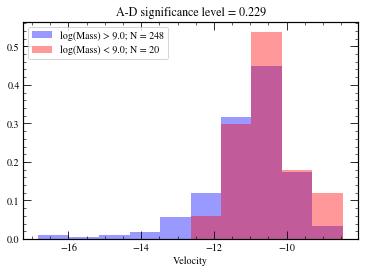

In [24]:
result = adplot(combined[combined.mass < 9].vel,combined[combined.mass > 9].vel,
                label1='log(Mass) < 9.0', label2='log(Mass) > 9.0', xlabel='Velocity')

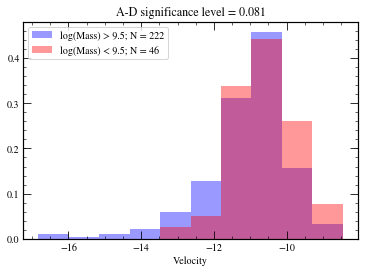

In [30]:
result = adplot(combined[combined.mass < 9.5].vel,combined[combined.mass > 9.5].vel,
                label1='log(Mass) < 9.5', label2='log(Mass) > 9.5', xlabel='Velocity')

/Users/dettman/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: p-value capped: true value larger than 0.25
  


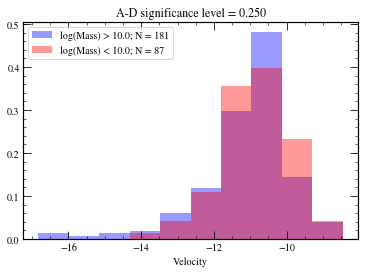

In [25]:
result = adplot(combined[combined.mass < 10].vel,combined[combined.mass > 10].vel,
                label1='log(Mass) < 10.0', label2='log(Mass) > 10.0', xlabel='Velocity')

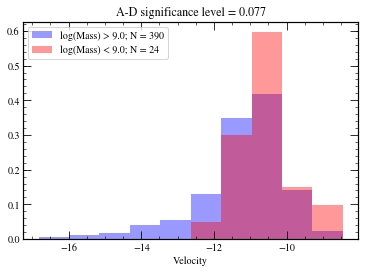

In [26]:
result = adplot(combined_all[combined_all.mass < 9].vel,combined_all[combined_all.mass > 9].vel,
                label1='log(Mass) < 9.0', label2='log(Mass) > 9.0', xlabel='Velocity')

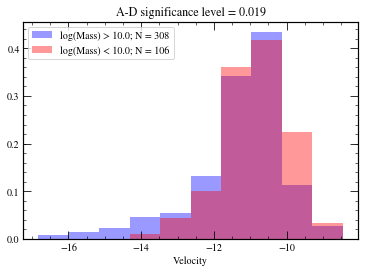

In [27]:
result = adplot(combined_all[combined_all.mass < 10].vel,combined_all[combined_all.mass > 10].vel,
                label1='log(Mass) < 10.0', label2='log(Mass) > 10.0', xlabel='Velocity')